<a href="https://colab.research.google.com/github/jrbobes/jrbobes-hitl-ml/blob/master/2024_HITL_XAI_Pancreas_RF_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HTIL_XAI_Pancreas_RF_rec**

author: jose.bobes at udc.es

# Importing required libraries

In [1]:
# Importing Required Libraries
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import numpy as np
print('numpy: {}'.format(np.__version__))

import re
print('re: {}'.format(re.__version__))

import graphviz
print('graphviz: {}'.format(graphviz.__version__))

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import sklearn
print('sklearn: {}'.format(sklearn.__version__))

from sklearn import metrics
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
scipy: 1.11.4
numpy: 1.25.2
re: 2.2.1
graphviz: 0.20.3
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


# Cleaning the Pancreas dataset

In [2]:
# 1. Set the FEATURE_NAMES to be used to train the model, except for the therapy_type which is the target.
features = ['ajcc_pathologic_stage',
            #'ajcc_pathologic_t',
            'ajcc_pathologic_m',
            'ajcc_pathologic_n',
            'age_at_index',
            #'other_dx',
            #'gender',
            #'race',
            #'ethnicity',
            'adenocarcinoma_invasion',
            'histological_type',
            'person_neoplasm_cancer_status',
            'year_of_initial_pathologic_diagnosis',
            'initial_pathologic_diagnosis_method',
            'surgery_performed_type',
            'number_of_lymphnodes_positive_by_he',
            #'number_of_lymphnodes_positive_by_ihc',
            'neoplasm_histologic_grade',
            'maximum_tumor_dimension',
            'residual_tumor',
            #'history_of_diabetes',
            #'family_history_of_cancer',
            #'radiation_therapy',
            #'postoperative_rx_tx',
            #'primary_therapy_outcome_success',
            #'new_tumor_events',
            #'days_to_new_tumor_event_after_initial_treatment',
            'therapy_type',
            #'tx_on_clinical_trial',
            #'drug_name',
            #'tobacco_smoking_history',
            #'alcoholic_exposure_category'
]

In [3]:
# 2. Load the dataset
url = "https://raw.githubusercontent.com/jrbobes/jrbobes-hitl-ml/master/tcga_paad_datosRecomendados.csv"

dataset = pd.read_csv(url, sep=';', usecols=features, encoding = "ISO-8859-1")
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print(dataset.shape)
print(dataset.head())

(185, 15)
  ajcc_pathologic_stage ajcc_pathologic_n ajcc_pathologic_m  age_at_index  \
0             Stage IIB                N1                MX            77   
1             Stage IIB                N1                M0            67   
2              Stage IB                N0                MX            59   
3             Stage IIA                N0                M0            61   
4             Stage IIA                N0                M0            65   

  adenocarcinoma_invasion                      histological_type  \
0                     YES  Pancreas-Adenocarcinoma-Other Subtype   
1                     YES    Pancreas-Adenocarcinoma Ductal Type   
2                     YES  Pancreas-Adenocarcinoma-Other Subtype   
3                     YES  Pancreas-Adenocarcinoma-Other Subtype   
4                     YES    Pancreas-Adenocarcinoma Ductal Type   

  person_neoplasm_cancer_status  year_of_initial_pathologic_diagnosis  \
0                    TUMOR FREE              

In [4]:
# 3. Show Datatypes
for column, dtype in zip(dataset.columns, dataset.dtypes):
    print(f"{column}:{dtype}")

ajcc_pathologic_stage:object
ajcc_pathologic_n:object
ajcc_pathologic_m:object
age_at_index:int64
adenocarcinoma_invasion:object
histological_type:object
person_neoplasm_cancer_status:object
year_of_initial_pathologic_diagnosis:float64
initial_pathologic_diagnosis_method:object
surgery_performed_type:object
number_of_lymphnodes_positive_by_he:float64
neoplasm_histologic_grade:object
maximum_tumor_dimension:float64
residual_tumor:object
therapy_type:object


In [5]:
# 4. Missing Values/ Null Values
print(dataset.isnull().sum())

ajcc_pathologic_stage                    3
ajcc_pathologic_n                        1
ajcc_pathologic_m                        0
age_at_index                             0
adenocarcinoma_invasion                  0
histological_type                        1
person_neoplasm_cancer_status           53
year_of_initial_pathologic_diagnosis     1
initial_pathologic_diagnosis_method      5
surgery_performed_type                   2
number_of_lymphnodes_positive_by_he      4
neoplasm_histologic_grade                0
maximum_tumor_dimension                 15
residual_tumor                          12
therapy_type                            64
dtype: int64


In [6]:
# 5. Fill in the missing values
#dataset.days_to_death = dataset.days_to_death.fillna(18250) # Asignamos un valor muy alto (50 años)
dataset.ajcc_pathologic_stage = dataset.ajcc_pathologic_stage.fillna('Stage 0')
#dataset.ajcc_pathologic_t = dataset.ajcc_pathologic_t.fillna('TX')
dataset.ajcc_pathologic_m = dataset.ajcc_pathologic_m.fillna('MX')
dataset.ajcc_pathologic_n = dataset.ajcc_pathologic_n.fillna('NX')
#dataset.race = dataset.race.fillna('Unknown')
#dataset.ethnicity = dataset.ethnicity.fillna('Unknown')
#dataset.person_neoplasm_cancer_status = dataset.person_neoplasm_cancer_status.fillna('Unknown')
dataset.therapy_type = dataset.therapy_type.fillna('Other')
dataset.number_of_lymphnodes_positive_by_he = dataset.number_of_lymphnodes_positive_by_he.fillna(dataset.number_of_lymphnodes_positive_by_he.mean())
#dataset.number_of_lymphnodes_positive_by_ihc = dataset.number_of_lymphnodes_positive_by_ihc.fillna(dataset.number_of_lymphnodes_positive_by_ihc.mean())
#dataset.days_to_new_tumor_event_after_initial_treatment = dataset.days_to_new_tumor_event_after_initial_treatment.fillna(dataset.days_to_new_tumor_event_after_initial_treatment.mean())
#dataset.tx_on_clinical_trial = dataset.tx_on_clinical_trial.fillna('Unknown')
#dataset.drug_name = dataset.drug_name.fillna('None')
#dataset.tobacco_smoking_history = dataset.tobacco_smoking_history.fillna(0)
#dataset.alcoholic_exposure_category = dataset.alcoholic_exposure_category.fillna('None')

dataset.histological_type = dataset.histological_type.fillna('None')
dataset.person_neoplasm_cancer_status = dataset.person_neoplasm_cancer_status.fillna('Unknown')
dataset.year_of_initial_pathologic_diagnosis = dataset.year_of_initial_pathologic_diagnosis.fillna(dataset.year_of_initial_pathologic_diagnosis.mean())
dataset.initial_pathologic_diagnosis_method = dataset.initial_pathologic_diagnosis_method.fillna('Unknown')
dataset.surgery_performed_type = dataset.surgery_performed_type.fillna('Unknown')
dataset.maximum_tumor_dimension = dataset.maximum_tumor_dimension.fillna(dataset.maximum_tumor_dimension.mean())
dataset.residual_tumor = dataset.residual_tumor.fillna('Unknown')
#dataset.history_of_diabetes = dataset.history_of_diabetes.fillna('Unknown')
#dataset.family_history_of_cancer = dataset.family_history_of_cancer.fillna('Unknown')
#dataset.radiation_therapy = dataset.radiation_therapy.fillna('Unknown')
#dataset.postoperative_rx_tx = dataset.postoperative_rx_tx.fillna('Unknown')
#dataset.primary_therapy_outcome_success = dataset.primary_therapy_outcome_success.fillna('Unknown')
#dataset.new_tumor_events = dataset.new_tumor_events.fillna('Unknown')

dataset_null = dataset.isnull()
print(dataset.isnull().sum())

ajcc_pathologic_stage                   0
ajcc_pathologic_n                       0
ajcc_pathologic_m                       0
age_at_index                            0
adenocarcinoma_invasion                 0
histological_type                       0
person_neoplasm_cancer_status           0
year_of_initial_pathologic_diagnosis    0
initial_pathologic_diagnosis_method     0
surgery_performed_type                  0
number_of_lymphnodes_positive_by_he     0
neoplasm_histologic_grade               0
maximum_tumor_dimension                 0
residual_tumor                          0
therapy_type                            0
dtype: int64


In [7]:
# 6. Removing Redundancy
count_duplicates = dataset[dataset.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 0


In [8]:
# There are 6 duplicates with the columns selected.
dataset[dataset.duplicated()]

,ajcc_pathologic_stage,ajcc_pathologic_n,ajcc_pathologic_m,age_at_index,adenocarcinoma_invasion,histological_type,person_neoplasm_cancer_status,year_of_initial_pathologic_diagnosis,initial_pathologic_diagnosis_method,surgery_performed_type,number_of_lymphnodes_positive_by_he,neoplasm_histologic_grade,maximum_tumor_dimension,residual_tumor,therapy_type


# Data Preparation

In [9]:
# 1. Simplify Target with only Chemotherapy or Other
dataset['therapy_type'] = dataset['therapy_type'].replace('Hormone Therapy', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Vaccine', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Ancillary', 'Other')

# check that we only get two values: 'Chemotherapy' and 'Other'
dataset['therapy_type'].unique()

array(['Chemotherapy', 'Other'], dtype=object)

In [10]:
# 2. Convert categorical variables into numerical.
# Categorical features need to be transformed before they can be used in a model.

dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage 0', 0)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage I', 1)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IA', 2)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IB', 3)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage II', 4)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIA', 5)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIB', 6)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage III', 7)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IV', 8)

#dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('TX', 0)
#dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T1', 1)
#dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T2', 2)
#dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T3', 3)
#dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T4', 4)

dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N0', 0)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1', 1)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1b', 2)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('NX', 3)

dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M0', 0)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M1', 1)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('MX', 2)

In [11]:
# 3. Drop unneeded Features
# Remove therapy_type from the X vector, and keep it as the target.
X = dataset.drop(['therapy_type'], axis=1)
y = dataset['therapy_type']

In [12]:
# 4. Use One-hot encoding for the rest of categorical features. We get a binary variable for each category.
X_encoded = pd.get_dummies(X)

In [13]:
# 5. Split the data in train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3,random_state=42)

# Creating a Random Forest model

In [14]:
# 1. Get the best possible parameters for a Random Forest
rf_best_acc = 0

for criterion in "gini", "entropy":
    for max_depth in [2,3,4,5,6, 10]:
        for min_samples_leaf in [5, 10]:
            drf = RandomForestClassifier(max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)
            drf.fit(X_train, y_train)
            predicitions = drf.predict(X_test)
            rf_acc = metrics.accuracy_score(y_test, predicitions)
            if rf_acc > rf_best_acc:
                rf_best_params = f"criterion: {criterion}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
                rf_best_acc = rf_acc

print("Random Forest Best Parameters: ", rf_best_params)
print("Random Forest Best Accuracy: ", rf_best_acc)

Random Forest Best Parameters:  criterion: gini, max_depth: 4, min_samples_leaf: 5
Random Forest Best Accuracy:  0.5357142857142857


In [15]:
# 2. Create the Decision Tree model and fit the training data
rf_clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, min_samples_leaf=5)
rf_clf = rf_clf.fit(X_train, y_train)

In [16]:
# 3. Predict over the test data and show accuracy
y_rf_pred = rf_clf.predict(X_test)
rf_acc = metrics.accuracy_score(y_test, y_rf_pred)
print("Random Forrest Tree accuracy: ", rf_acc)

Random Forrest Tree accuracy:  0.5178571428571429


In [17]:
# 4. Show Classification Report
print(metrics.classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

Chemotherapy       0.52      1.00      0.68        29
       Other       0.00      0.00      0.00        27

    accuracy                           0.52        56
   macro avg       0.26      0.50      0.34        56
weighted avg       0.27      0.52      0.35        56



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


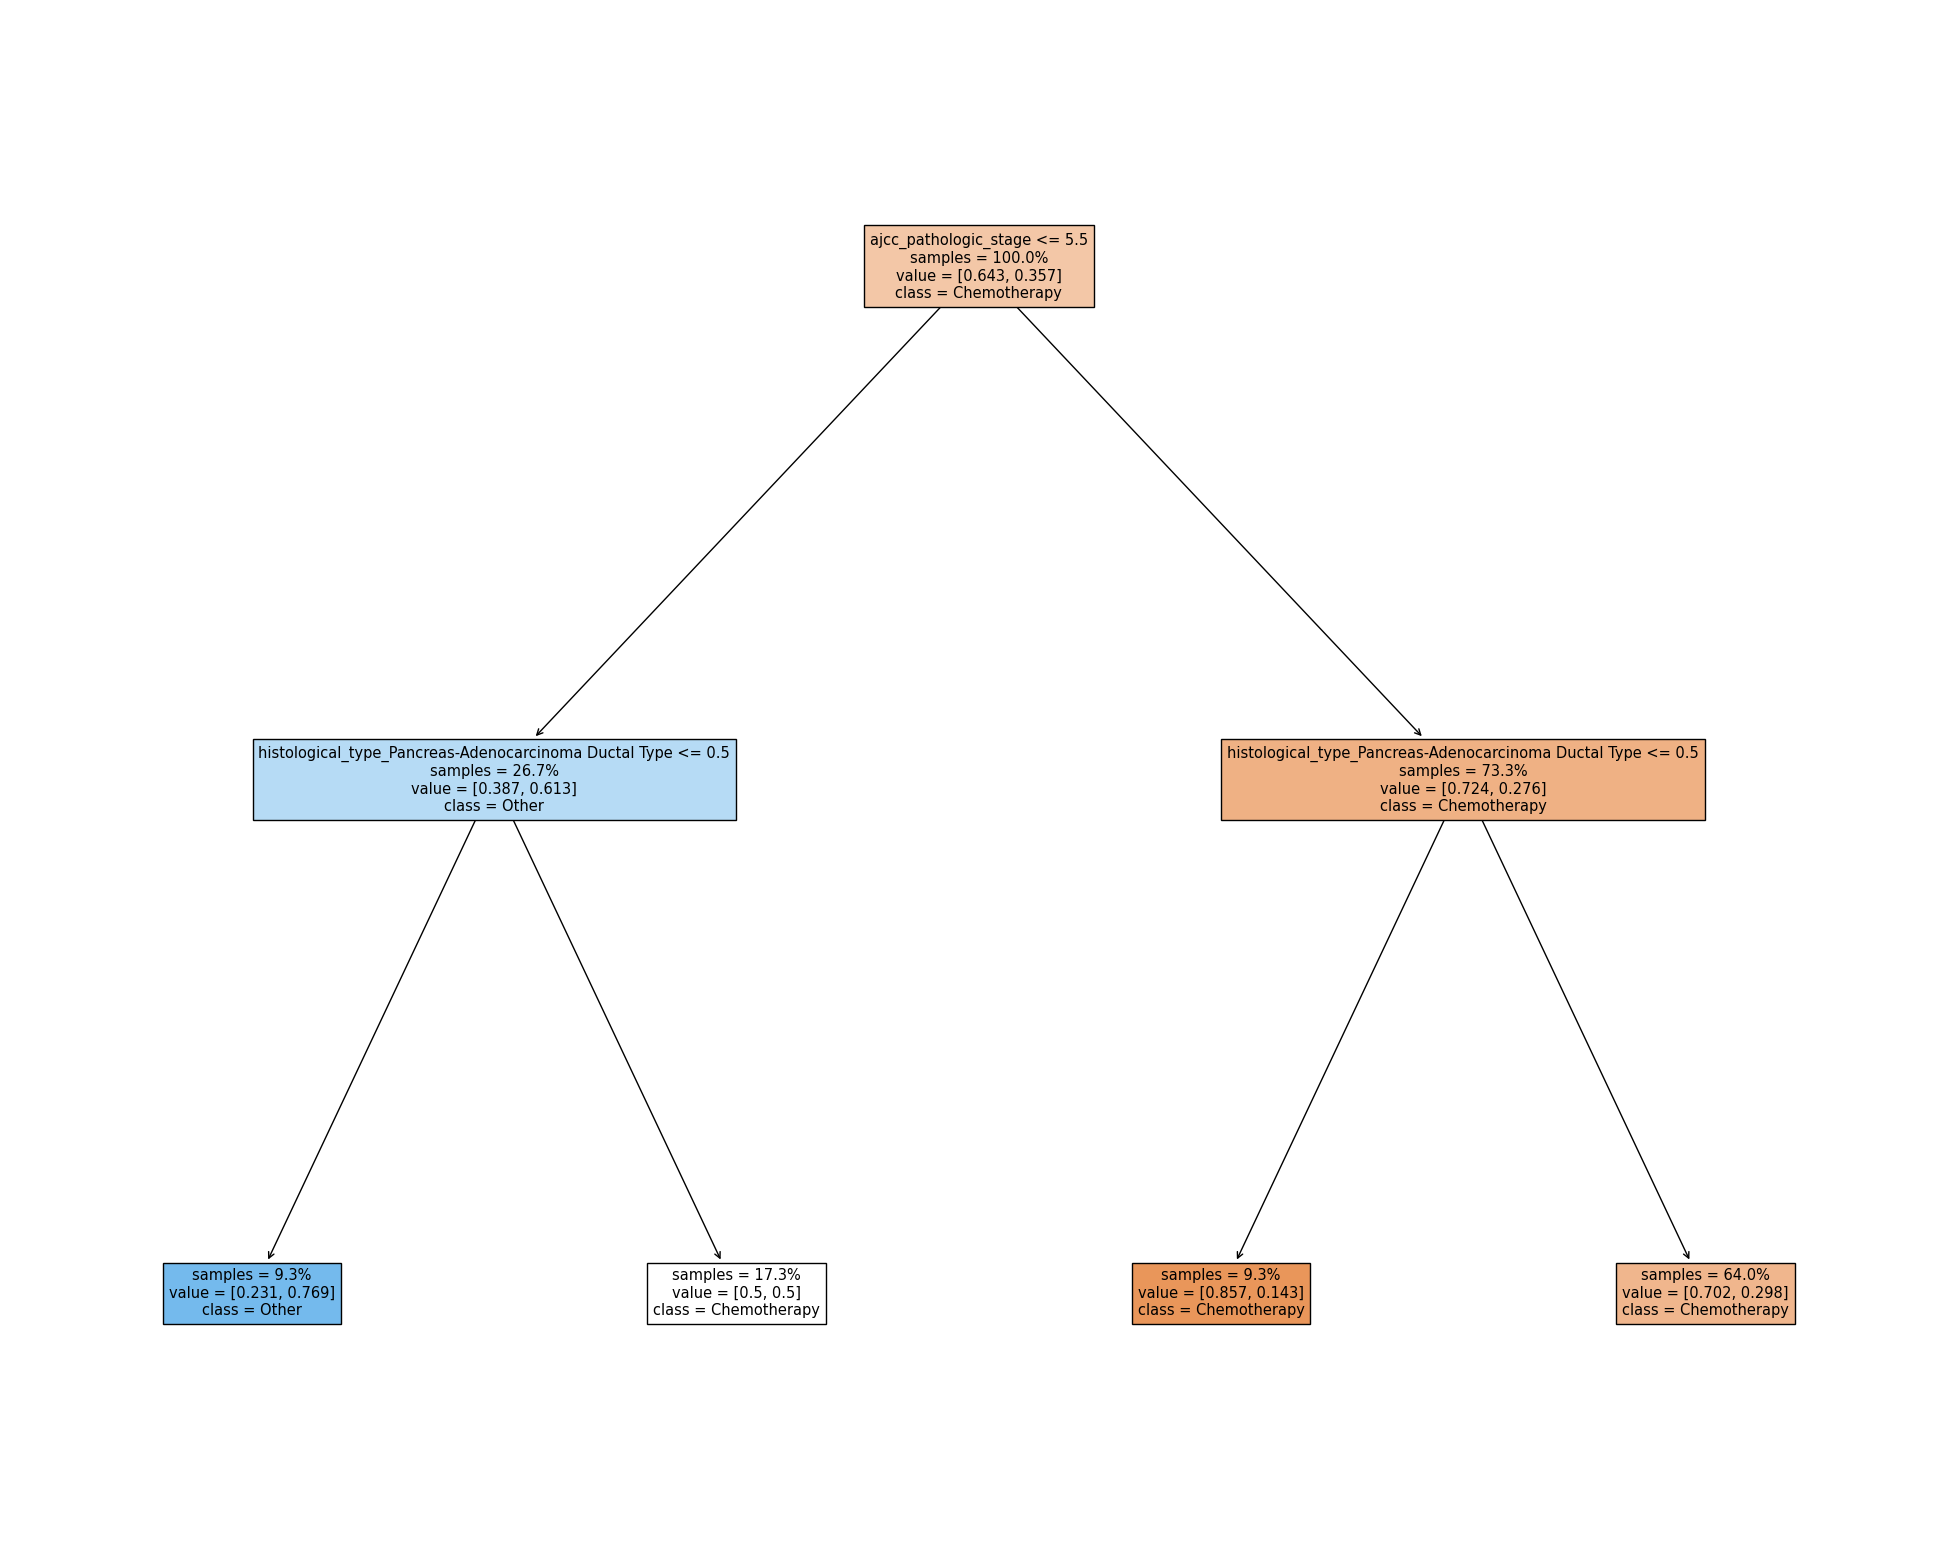

In [18]:
# 5. Visualize the Random Forest decision tree
rf_fig = plt.figure(figsize=((25,20)))
tree.plot_tree(rf_clf.estimators_[0],
            feature_names = X_encoded.columns,
            class_names=['Chemotherapy','Other'],
            impurity=False,
            proportion=True,
            filled=True)
rf_fig.savefig('rf_tree.png')
plt.show()

In [19]:
print('Training set metrics:')
print('Accuracy:', accuracy_score(y_train, rf_clf.predict(X_train)))
#print('Precision:', precision_score(y_train, rf_clf.predict(X_train)))
#print('Recall:', recall_score(y_train, rf_clf.predict(X_train)))

print('Test set metrics:')
print('Accuracy:', accuracy_score(y_test, rf_clf.predict(X_test)))
#print('Precision:', precision_score(y_test, rf_clf.predict(X_test)))
#print('Recall:', recall_score(y_test, rf_clf.predict(X_test)))

Training set metrics:
Accuracy: 0.6976744186046512
Test set metrics:
Accuracy: 0.5178571428571429


<Axes: >

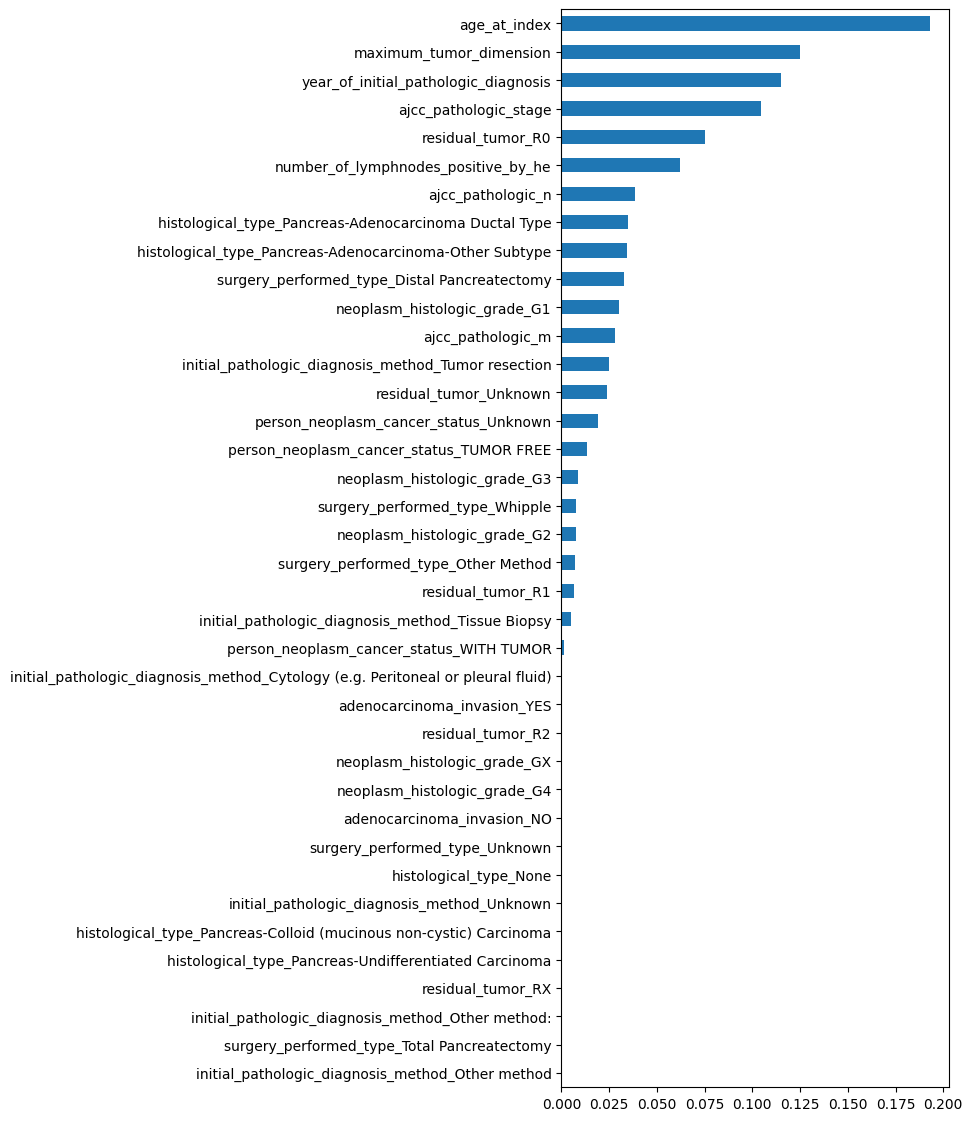

In [20]:
# 6. Feature Importance of the model
feat_importances = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(5,14), legend=False)

# Permutation Importance

In [ ]:
# 1. Install required package
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=b52b83a0a7ced1ad1498b957e4f10ea84d3a749c2711affd6ce02dbe0e13366f
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
# 2. Get permutation importance data and show weights
rf_perm = PermutationImportance(rf_clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(rf_perm, feature_names = X_encoded.columns.tolist())

Weight,Feature
0.0270 ± 0.0000,ajcc_pathologic_stage
0.0270 ± 0.0000,maximum_tumor_dimension
0.0270 ± 0.0000,initial_pathologic_diagnosis_method_Tissue Biopsy
0.0270 ± 0.0000,surgery_performed_type_Distal Pancreatectomy
0.0270 ± 0.0000,ajcc_pathologic_n
0.0270 ± 0.0000,histological_type_Pancreas-Adenocarcinoma Ductal Type
0.0270 ± 0.0000,person_neoplasm_cancer_status_TUMOR FREE
0.0216 ± 0.0216,year_of_initial_pathologic_diagnosis
0.0216 ± 0.0216,number_of_lymphnodes_positive_by_he
0.0216 ± 0.0216,surgery_performed_type_Whipple


# Explainability with SHAP

In [ ]:
!pip install shap
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Explain the model's predictions using SHAP
explainerShap = shap.TreeExplainer(rf_clf)

# Compute shap_values for X_test
shap_values = explainerShap.shap_values(X_test)

Summary plot will give us the variable importance plot. Features with high predicting power are shown at the top and the ones with low predicting powers are shown at the bottom.

We could see the contribution of each data into the prediction probability. The redder the colour, the higher the value and vice versa. Also, when the value is on the positive side, it contributes to the class 0 prediction result probability and vice versa.

Variable Importance Plot - Global Interpretation


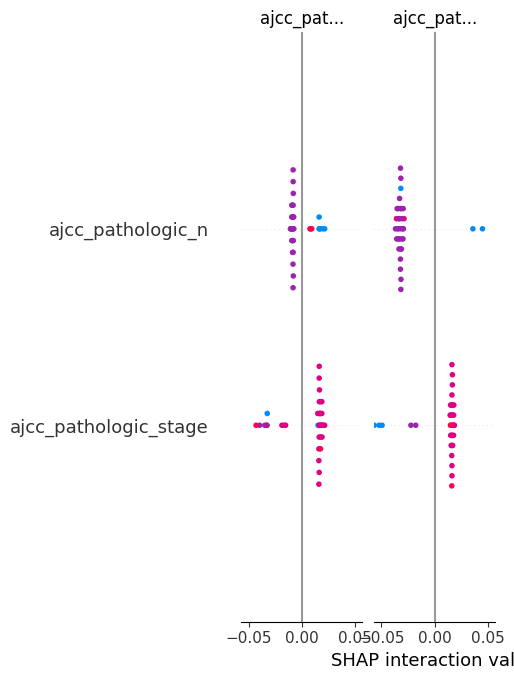

In [ ]:
print("Variable Importance Plot - Global Interpretation")
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names=['Chemotherapy','Other'])

In [ ]:
# Summary plot in an individual sample
shap.summary_plot(shap_values[0], X_test)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

The **partial dependence plot** is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

In [ ]:
shap.dependence_plot('age_at_index', shap_values[1], X_test, interaction_index='age_at_index')

A continuación incluimos un gráfico de decisión:

In [ ]:
i=1
shap.decision_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

Y finalmente un gráfico de fuerzas:

In [ ]:
shap.initjs()
i = 1
shap.force_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

# Explainability with LIME

LIME (Local Interpretable Model-Agnostic Explanations) is a method for explaining the predictions of any classifier and regressor (model agnostic).

In [21]:
# Install LIME
!pip install lime

# Import required libraries
from lime.lime_tabular import LimeTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=29a5c31e3a9c9a253bb935077fce2f17556830e447ed07d0fbdd8033826458bc
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


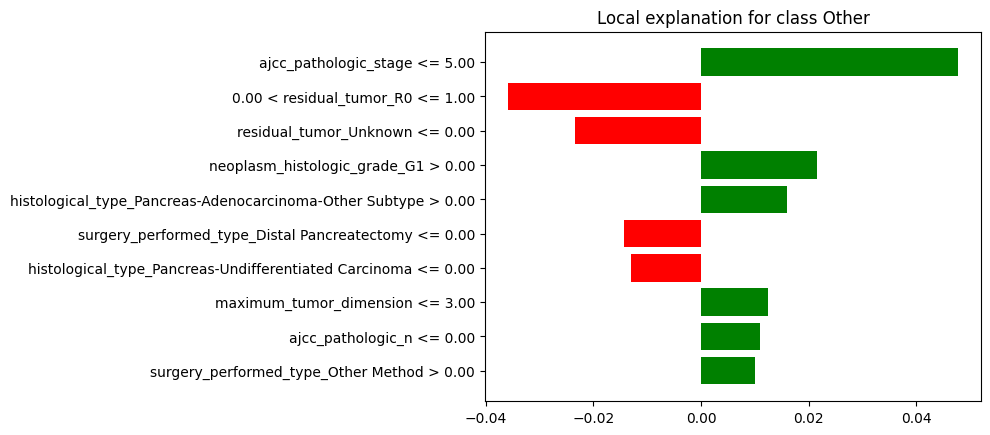

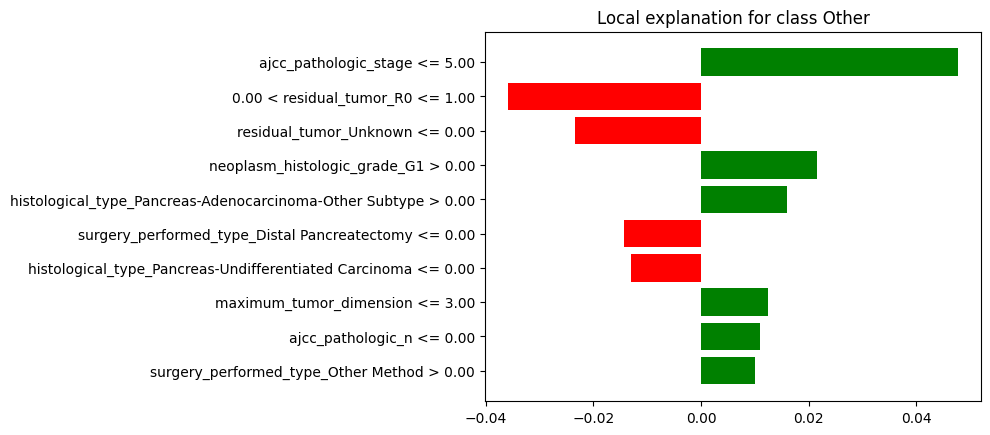

In [22]:
# XAI with LIME (Local Interpretable Model-agnostic Explanations)
explainerLime = LimeTabularExplainer(X_encoded.values, feature_names=X_encoded.columns, class_names = ['Chemotherapy', 'Other'], discretize_continuous=True)
#explainer2 = LimeTabularExplainer(X_encoded.values[:,:], feature_names = X_encoded.columns,class_names=['Chemotherapy','Other'], discretizer='decile',kernel_width=5,discretize_continuous=True,verbose=True)

# Patient 3 LIME explanation
expPatient3 = explainerLime.explain_instance(X_encoded.values[2], rf_clf.predict_proba, num_features=10, top_labels=5)
#exp2 = explainer2.explain_instance(X_encoded.iloc[1,:],rf_clf.predict_proba)

expPatient3.show_in_notebook(show_all=True)
expPatient3.as_pyplot_figure()


In [ ]:
# Patient 4 LIME explanation
#expPatient4 = explainerLime.explain_instance(X_encoded.values[3], rf_clf.predict_proba, num_features=10, top_labels=3)
#expPatient4.show_in_notebook(show_all=True)
#expPatient4.as_pyplot_figure()

In [23]:
import warnings
warnings.filterwarnings('ignore')

#Get the overall most common important features
feature_importance = {}
# Get, for each patient, the most important feature
for idx, i in enumerate(X_encoded.values): #X_encoded.values[:3]
  expl = explainerLime.explain_instance(i, rf_clf.predict_proba, num_features=20, top_labels=20)

  # Iterate over the set of features
  for jdx, j in enumerate(expl.as_list()):

    # Get feature and value
    splitedj = str(j[0]).split()
    if (len(splitedj) == 5):
      feature_name = splitedj[2]
    else:
      feature_name = splitedj[0]

    feature_importance_value = abs(j[1])

    #print(str(idx) + "-" + str(jdx) + " - feature: " + feature_name + " = " + str(feature_importance_value))

    # Add new value to the feature (average)
    if feature_name in feature_importance:
      previous_value = feature_importance[feature_name]
      new_value = (previous_value + feature_importance_value) / 2
      #print("  *previous_value = " + str(previous_value) + " / new value = " + str(new_value))
    else:
      new_value = feature_importance_value
      #print("new value = " + str(feature_importance_value))

    feature_importance[feature_name] = new_value

# Print dictionary order by feature importance value
dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse = True))

{'ajcc_pathologic_stage': 0.038582700384149474,
 'residual_tumor_R0': 0.03688095924074576,
 'age_at_index': 0.030155259361180388,
 'neoplasm_histologic_grade_G1': 0.02127587512269741,
 'residual_tumor_Unknown': 0.020416866944842647,
 'histological_type_Pancreas-Adenocarcinoma-Other': 0.02003680671034339,
 'surgery_performed_type_Distal': 0.018243380771081445,
 'maximum_tumor_dimension': 0.01371098591711781,
 'ajcc_pathologic_n': 0.012455994729796506,
 'number_of_lymphnodes_positive_by_he': 0.011676637698012996,
 'adenocarcinoma_invasion_NO': 0.009995846430451833,
 'histological_type_Pancreas-Undifferentiated': 0.008594033915797255,
 'histological_type_None': 0.008081923622622621,
 'residual_tumor_R2': 0.007211647013284315,
 'surgery_performed_type_Total': 0.007026979017553836,
 'surgery_performed_type_Unknown': 0.006910488262532978,
 'surgery_performed_type_Other': 0.006904131238815023,
 'year_of_initial_pathologic_diagnosis': 0.006891732775128543,
 'initial_pathologic_diagnosis_method